# ANLY-590 Assignment 3

## 1 Autoencoder

Build and fit a convolutional autoencoder for the Fashion MNIST dataset.
The components of this network will be many of the same pieces we’ve used
with convolutional classification networks: Conv2D, MaxPooling, and so on.
The encoder part of the network should run the input image through a few
convolutional layers of your choice. The decoder part of the network will utilize
UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html. DO
NOT JUST COPY THIS CODE AND TURN IT IN. BE CREATIVE, COME
UP WITH YOUR OWN VARIATION.

After training your network, visualize some examples of input images and
their decoded reconstruction.


In [9]:
#!python -m pip install --upgrade pip
#!pip install keras
#!pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
%matplotlib inline
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [2]:
import os
os.environ['KERAS_BACKEND']='tensorflow'

In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import fashion_mnist

Using TensorFlow backend.


(60000, 28, 28)


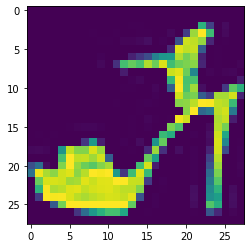

In [9]:
# Load Fashion MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Shape check and plotting
print(X_train.shape)
plt.imshow(X_train[9])

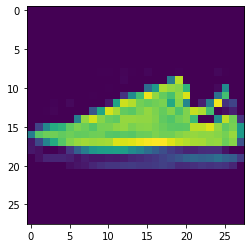

In [10]:
plt.imshow(X_train[6])

In [14]:
from keras.applications import VGG16
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Conv1D, MaxPooling1D
from keras.layers import Embedding, SimpleRNN, LSTM, GRU
from keras.models import Model, Sequential
from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils import np_utils
from keras.utils import np_utils
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

Using TensorFlow backend.


In [11]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [15]:
#  Train the autoencoder 
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [16]:
# Declaring a depth of 1
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

# Setting up values as float32s that are bounded between 0 and 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# Processing class labels 
# They are currently a numeric vector
# Need to transform them into categories
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [17]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# Check the shape
print(Y_train.shape)
print(Y_test.shape)

(60000, 10)
(10000, 10)


In [18]:
input_img = Input(shape=(28, 28, 1))

# set up encoder part of network
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8, 8, 16)

# set up decoder part of network
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [57]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 16)          0   

In [58]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 155s 3ms/step - loss: 0.3576 - val_loss: 0.3178
Epoch 2/20
60000/60000 [==============================] - 163s 3ms/step - loss: 0.3113 - val_loss: 0.3056
Epoch 3/20
60000/60000 [==============================] - 180s 3ms/step - loss: 0.3020 - val_loss: 0.3022
Epoch 4/20
60000/60000 [==============================] - 179s 3ms/step - loss: 0.2973 - val_loss: 0.2974
Epoch 5/20
60000/60000 [==============================] - 178s 3ms/step - loss: 0.2937 - val_loss: 0.2912
Epoch 6/20
60000/60000 [==============================] - 187s 3ms/step - loss: 0.2914 - val_loss: 0.2904
Epoch 7/20
60000/60000 [==============================] - 190s 3ms/step - loss: 0.2893 - val_loss: 0.2921
Epoch 8/20
60000/60000 [==============================] - 177s 3ms/step - loss: 0.2880 - val_loss: 0.2899
Epoch 9/20
60000/60000 [==============================] - 173s 3ms/step - loss: 0.2867 - val_loss: 0.2

<Figure size 432x288 with 0 Axes>

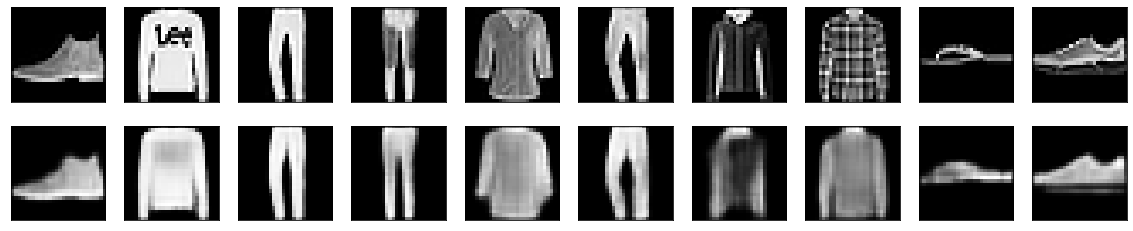

In [59]:
plt.clf()
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The top row is the original graphs , and the bottom row is the decoded reconstructions. Though We are losing quite a bit of detail with this approach, we can still distinguish what type of clothes those graphs represent.

## 2 Image Classification

### 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you’ve made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model’s performance on training
set and test set.


In [19]:
# CNN input layer
model = Sequential()
model.add(Conv2D(filters = 28,kernel_size=(6, 6), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))
print(model.output_shape)

(None, 23, 23, 28)


In [20]:
model.add(Conv2D(filters = 56,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', 
                 input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [21]:
# Setting up the fully connected layer
model.add(Flatten())
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 23, 23, 28)        1036      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 56)        14168     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 56)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 56)                313656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)               

So the model consists of 2 convolutional layers. First layer has 28 filters, 6 by 6 kernel size, 1 by 1 stride, no padding, and ReLu activation. Second layer has 56 filters, 3 by 3 kernel size, 1 by 1 stride, no padding, and ReLu activation.

The block maxpooling is 2 by 2, dropout at rate 0.25, with a layer of flattening into vector, and a dense layer of ReLu activation with 56 hidden nodes.

And the other dropout is at rate 0.5 with an output layer of 10 nodes with Softmax activation.

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
#print(Y_train)

In [75]:
model_training = model.fit(X_train, Y_train,
          epochs=20,
          batch_size=256,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2881 - acc: 0.8941 - val_loss: 0.2682 - val_acc: 0.9065
Epoch 2/20
60000/60000 [==============================] - 82s 1ms/step - loss: 0.2807 - acc: 0.8961 - val_loss: 0.2652 - val_acc: 0.9071
Epoch 3/20
60000/60000 [==============================] - 81s 1ms/step - loss: 0.2713 - acc: 0.9010 - val_loss: 0.2586 - val_acc: 0.9040
Epoch 4/20
60000/60000 [==============================] - 84s 1ms/step - loss: 0.2649 - acc: 0.9023 - val_loss: 0.2487 - val_acc: 0.9107
Epoch 5/20
60000/60000 [==============================] - 81s 1ms/step - loss: 0.2553 - acc: 0.9058 - val_loss: 0.2486 - val_acc: 0.9116
Epoch 6/20
60000/60000 [==============================] - 86s 1ms/step - loss: 0.2486 - acc: 0.9076 - val_loss: 0.2534 - val_acc: 0.9109
Epoch 7/20
60000/60000 [==============================] - 107s 2ms/step - loss: 0.2435 - acc: 0.9094 - val_loss: 0.2517 - val_ac

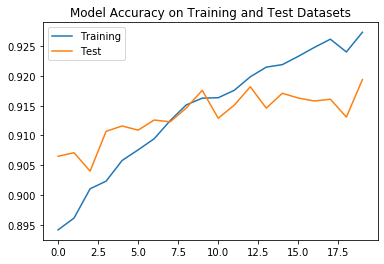

In [76]:
plt.plot(model_training.history["acc"], label="Training")
plt.plot(model_training.history["val_acc"], label="Test")
plt.legend()
plt.title("Model Accuracy on Training and Test Datasets")
plt.show()

The accuracy for the training set improves greatly, while the accuracy for the test set only improves slightly and is fluctuant. But the test accuracy starts at a higher accuracy point than the training accuracy.

### 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights
should be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model’s performance on training set and test set.

In [23]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [24]:
vggX_train = np.c_[X_train,X_train,X_train]
vggX_test = np.c_[X_test,X_test,X_test]

In [26]:
#!pip install --user tensorflow keras numpy pandas sklearn pillow

In [25]:
vggX_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in vggX_train])
vggX_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in vggX_test])

model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.25))
model2.add(Dense(10, activation="softmax"))

In [27]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


In [28]:
conv_base.trainable = False

In [29]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [30]:
model_vgg = model2.fit(vggX_train, Y_train,
          epochs=5,
          batch_size=256,
          validation_data=(vggX_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1169s 19ms/step - loss: 2.0043 - acc: 0.2708 - val_loss: 1.8131 - val_acc: 0.3523
Epoch 2/5
60000/60000 [==============================] - 1272s 21ms/step - loss: 1.7868 - acc: 0.3529 - val_loss: 1.7361 - val_acc: 0.3719
Epoch 3/5
60000/60000 [==============================] - 1294s 22ms/step - loss: 1.7307 - acc: 0.3698 - val_loss: 1.7006 - val_acc: 0.3820
Epoch 4/5
60000/60000 [==============================] - 1230s 20ms/step - loss: 1.7019 - acc: 0.3805 - val_loss: 1.6777 - val_acc: 0.3875
Epoch 5/5
60000/60000 [==============================] - 1234s 21ms/step - loss: 1.6783 - acc: 0.3886 - val_loss: 1.6658 - val_acc: 0.3923


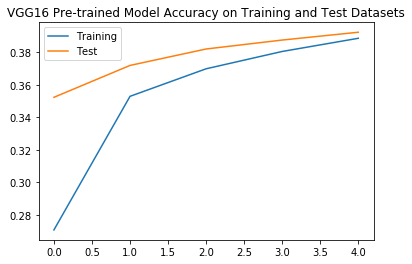

In [31]:
plt.plot(model_vgg.history["acc"], label="Training")
plt.plot(model_vgg.history["val_acc"], label="Test")
plt.legend()
plt.title("VGG16 Pre-trained Model Accuracy on Training and Test Datasets")
plt.show()

The graph shows that, the accuracy for the training set starts at a lower point and increases faster  than the test set. But for both training and test data, the accuracy finally approaching 0.39.

The accuracy is quite low, and the possible reason is that, I only ran 5 epoches since it is time-consuming. Maybe increasing the number of epochs can increase the accuracy.


##  3 Text Classification

### 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classification task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).


In [70]:
import csv
import pandas as pd
import re
from sklearn.model_selection import train_test_split

In [69]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [61]:
# csv file name 
filename = "tweets_with_labels.csv"
  
# initializing the titles and rows list 
fields = [] 
rows = [] 
  
# reading csv file 
with open(filename, 'r') as csvfile: 
    # creating a csv reader object 
    csvreader = csv.reader(csvfile) 
      
    # extracting field names through first row 
    fields = next(csvreader) 
  
    # extracting each data row one by one 
    for row in csvreader: 
        rows.append(row) 
    # get total number of rows 
    print("Total no. of rows: %d"%(csvreader.line_num)) 
    
# printing the field names 
print('Field names are:' + ', '.join(field for field in fields)) 
  
#  printing first 5 rows 
print('\nFirst 5 rows are:\n') 
for row in rows[:5]: 
    # parsing each column of a row 
    for col in row: 
        print("%10s"%col), 
    print('\n') 

Total no. of rows: 77947
Field names are:id	tweet	k1	k2	k3	k4	k5	k6	k7	k8	k9	k10	k11	k12	k13	k14	k15

First 5 rows are:

1	Jazz for a Rainy Afternoon:  {link}	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0


2	RT: @mention: I love rainy days.	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0


3	Good Morning Chicago! Time to kick the Windy City in the nuts and head back West!	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0


6	Preach lol! :) RT @mention: #alliwantis this type of weather all the time.. I live for beautiful days like this! #minneapolis	0	0	0	0	0	0	0.604	0	0.196	0	0	0	0.201	0	0


9	@mention good morning sunshine	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0




In [71]:
df = pd.read_csv('tweets_with_labels.csv',sep='\t',error_bad_lines=False)
df.dropna()

# get labels for our dataset
df_labels = df[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9','k10', 'k11', 'k12', 'k13', 'k14', 'k15']]

# preprocessing function
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

# preprocessing
corpus = list(df["tweet"])

In [72]:
chars = sorted(list(set(''.join(corpus))))
print('total chars:', len(chars))

total chars: 94


In [73]:
X = [preprocess_text(sen) for sen in corpus]
y = df_labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# tokenizer and convert to input
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
# Max number of words
max_features = 10000

max_len = 64

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [77]:
# build model

from tensorflow.keras.layers import LSTM,Embedding

class TextLSTM():
    def __init__(self,max_len,max_features):
        self.max_len = max_len
        self.max_features = max_features
        self.model = self.build_model()

    def build_model(self):
        input_sen = Input(shape=(self.max_len,))
        x = Embedding(self.max_features, 32)(input_sen)
        x = LSTM(32)(x)
        output = Dense(15, activation='sigmoid')(x)
        return Model(input_sen,output)

    def fit(self,x_train,y_train,x_test,y_test):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
        res = self.model.fit(x_train, y_train,
                       epochs=20,
                       batch_size=64,
                       shuffle=True,
                       validation_data=(x_test, y_test))
       
        return res

In [78]:
TL = TextLSTM(max_len,max_features)
history_LSTM = TL.fit(X_train,y_train,X_test,y_test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 64, 32)            320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                495       
Total params: 328,815
Trainable params: 328,815
Non-trainable params: 0
_________________________________________________________________
Train on 54562 samples, validate on 23384 samples
Epoch 1/20
54562/54562 [==============================] - 36s 664us/sample - loss: 2.7090 - accuracy: 0.2882 - val_loss: 2.6799 - val_accuracy: 0.2875
Epoch 2/20
54562/54562 [==========================

The RNN model has 81.54% accuracy on traning set and 80.74% on test set.

### 3.2 CNN

In [80]:
from tensorflow.keras.layers import Dropout,Conv1D,GlobalMaxPooling1D

class TextCNN():
    def __init__(self,max_len,max_features):
        self.max_len = max_len
        self.max_features = max_features
        self.model = self.build_model()

    def build_model(self):
        input_sen = Input(shape=(self.max_len,))
        x = Embedding(self.max_features, 32)(input_sen)
        x = Conv1D(64,3,padding='same',activation='relu',strides=1)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(150,activation="relu")(x)
        output = Dense(15, activation='sigmoid')(x)
        return Model(input_sen,output)

    def fit(self,x_train,y_train,x_test,y_test):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
        res = self.model.fit(x_train, y_train,
                       epochs=5,
                       batch_size=64,
                       shuffle=True,
                       validation_data=(x_test, y_test))
       
        return res

In [81]:
TC = TextCNN(max_len,max_features)
history_CNN = TC.fit(X_train,y_train,X_test,y_test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 64, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 64)            6208      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               9750      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                2265      
Total params: 338,223
Trainable params: 338,223
Non-trainable params: 0
_____________________________________________________

The CNN model has 85.05% accuracy on training set and 82.37% on test set.

### 3.3

In [93]:
from sklearn.metrics import roc_curve, auc

In [90]:
def plot_roc(test_TL,test_TC,test_target,i):
    fprl, tprl, _ = roc_curve(test_target,test_TL)
    fprc, tprc,_ = roc_curve(test_target,test_TC)
    plt.figure()
    lw = 0.5
    # RNN
    plt.plot(fprl, tprl, color='blue',
             lw=lw, label='ROC curve for RNN (area = %0.3f)' % auc(fprl,tprl))
    # CNN
    plt.plot(fprc, tprc, color='orange',
             lw=lw, label='ROC curve for CNN (area = %0.3f)' % auc(fprc,tprc))
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for label k%s' % str(i+1))
    plt.legend(loc="lower right")
    plt.show()

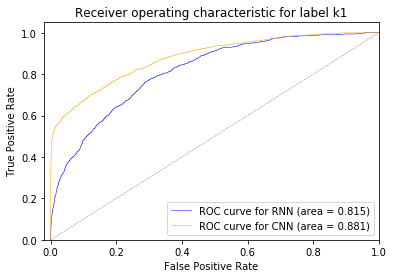

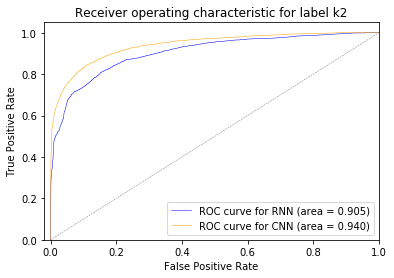

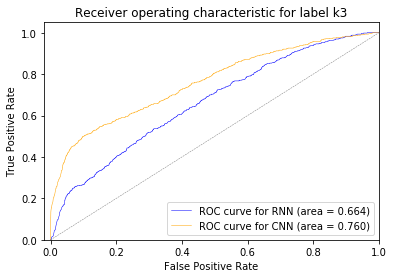

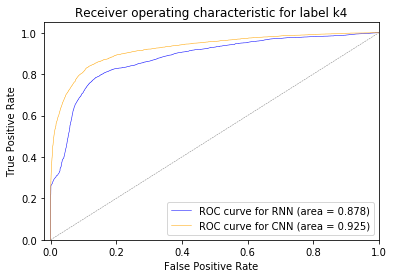

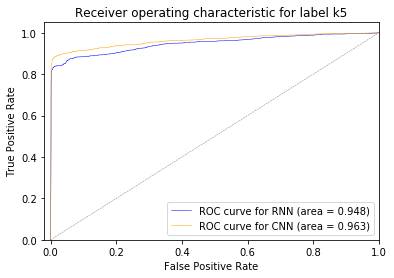

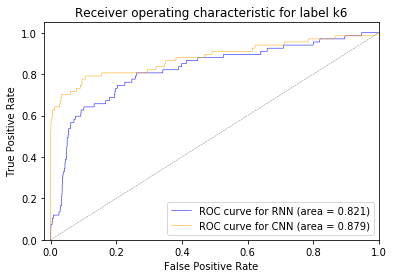

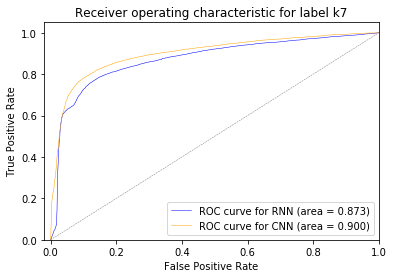

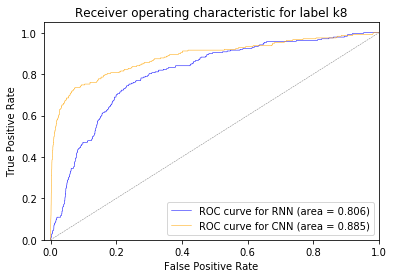

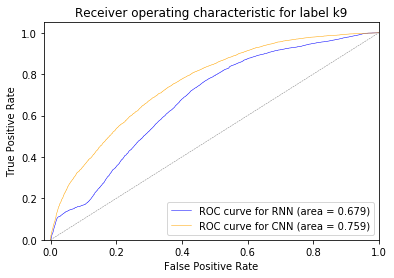

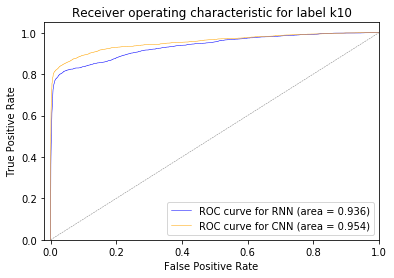

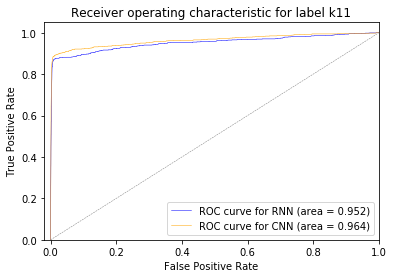

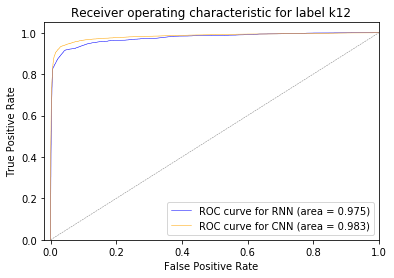

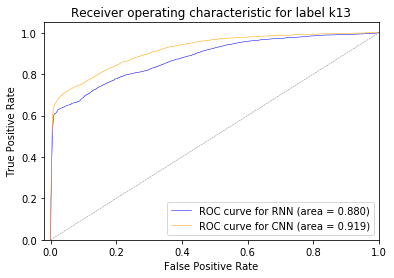

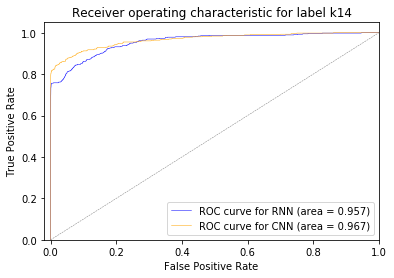

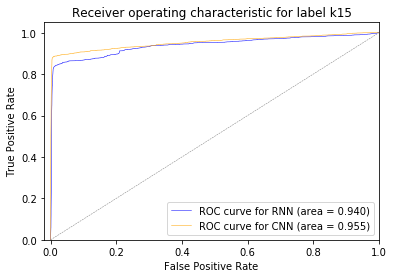

In [92]:
for i in range(15):
    test_TL = TL.model.predict(X_test)[:,i]
    test_TC = TC.model.predict(X_test)[:,i]
    test_target = y_test[:,i]>0
    plot_roc(test_TL,test_TC,test_target,i)

From these graphs, we can see ROC curves for CNN are always above the ROC curves for RNN. So CNN performs better than RNN for most labels in this case.